In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils and ages
from dlnpyutils.utils import bspline,mad,interp
import ages as ages

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# functools
from functools import partial

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25,'axes.facecolor':'w'})
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# pdb
import pdb

# tqdm 
from tqdm.notebook import tqdm

In [3]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# APOGEE LMC 

In [4]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [5]:
len(np.unique(lmcdr17['FIELD']))

36

In [6]:
### Position/Distances of the LMC stars

from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

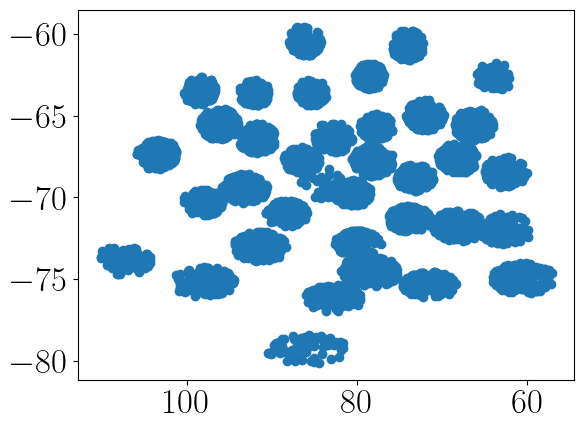

In [7]:
plt.scatter(lmcdr17['RA'],lmcdr17['DEC'])
plt.gca().invert_xaxis()

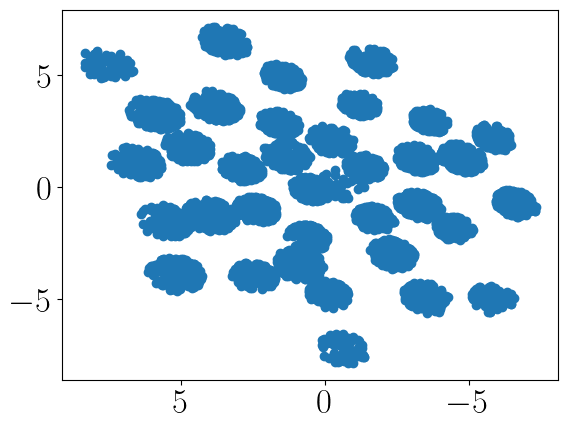

In [8]:
plt.scatter(lmcx,lmcy)
plt.gca().invert_xaxis()

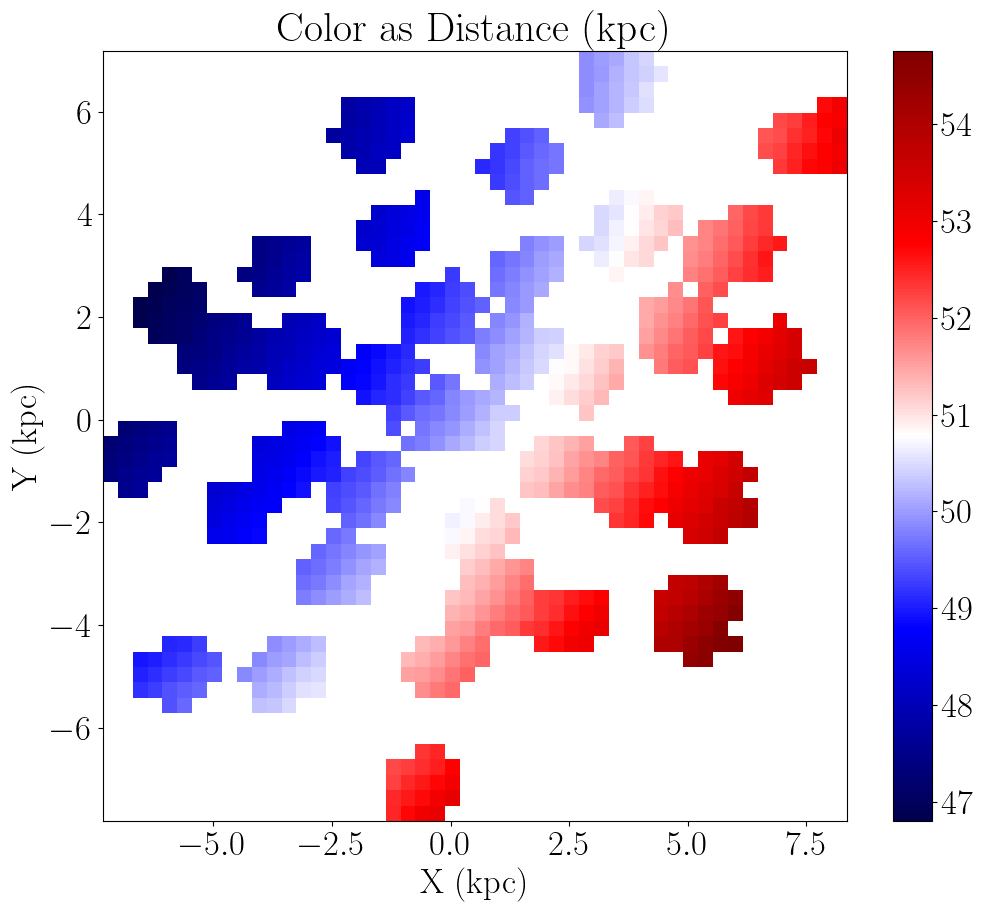

In [9]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,lmcdis,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='seismic')
plt.colorbar()

# plt.gca().invert_xaxis()

plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

# Calculated Age Read in 

In [10]:
agetab = Table.read('lmc_lm_wgtage_21OCT2022.fits')

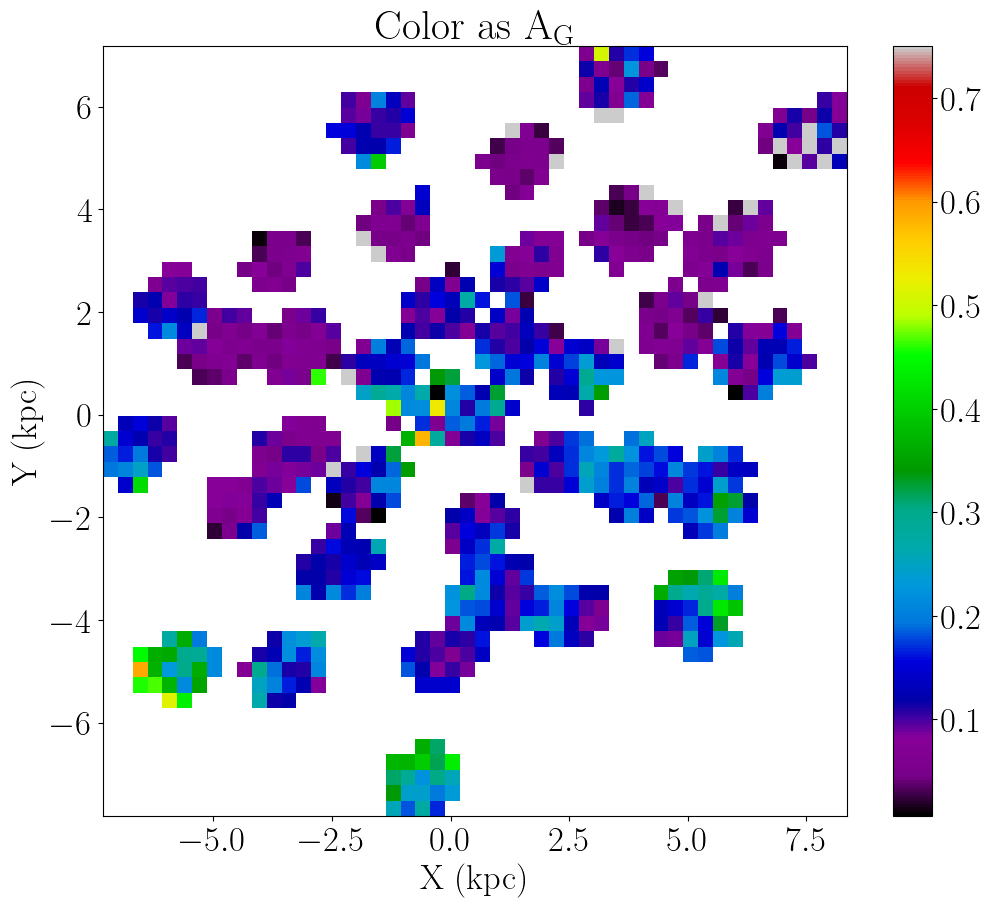

In [11]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=0.75)
plt.colorbar()

plt.title(r'Color as A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

(array([2665., 1865.,  818.,  258.,  101.,   30.,    9.,    5.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

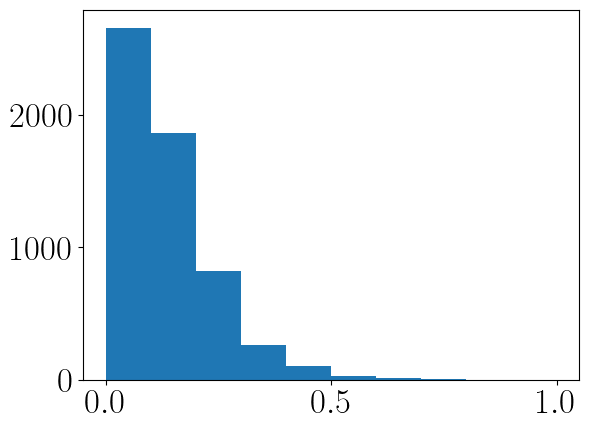

In [12]:
plt.hist(agetab['EXT'][:,1],range=(0,1))

# LMC SFH

In [13]:
north = Table.read('region_north_SFH_2.txt',format='ascii')
south = Table.read('region_south_SFH_2.txt',format='ascii')

In [14]:
north.columns

<TableColumns names=('Age_min','Age_max','SFR','err_SFR','SFR_times_area','err_SFR_times_area','Z','err_Z')>

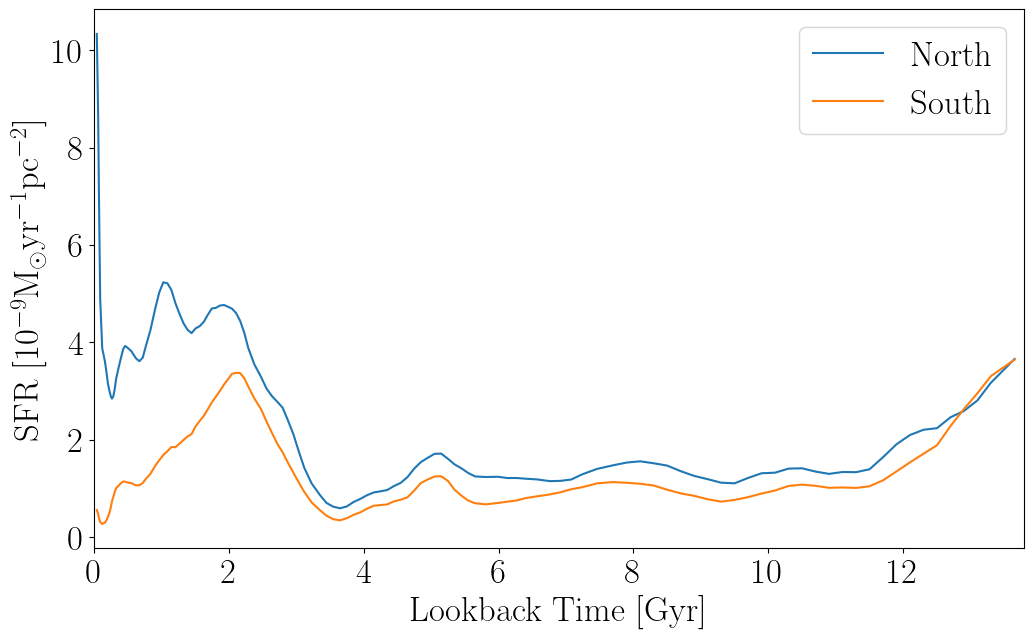

In [15]:
plt.figure(figsize=[12,7])
plt.plot((north['Age_max']+north['Age_min'])/2.,north['SFR'],label='North')
plt.plot((south['Age_max']+south['Age_min'])/2.,south['SFR'],label='South')
plt.legend()
plt.xlim(0,13.787)
plt.xlabel(r'Lookback Time [Gyr]')
plt.ylabel(r'SFR [${\rm 10^{-9} M_\odot yr^{-1} pc^{-2}}$]')
plt.savefig('smash_sfh_plot.png',bbox_inches='tight')
plt.show()

In [16]:
select_results = Table.read('lmc_rgbmembers_selectfunc2.fits.gz')

In [17]:
np.arange(0,20,20/100)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
       11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
       19.8])

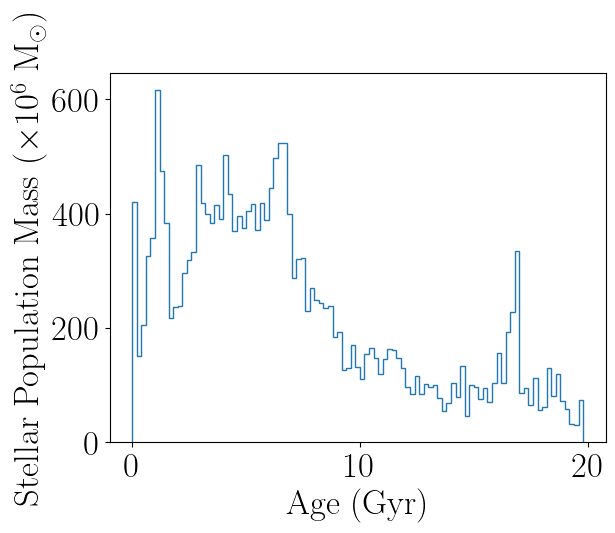

In [18]:
# plt.subplot(212)
plt.hist(agetab['AGE'],weights=select_results['stellarmass']/10**6,bins=np.arange(0,20,20/100),histtype='step')
# plt.yscale('log')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Stellar Population Mass ($\times 10^6$ M$_\odot$)')
# plt.savefig('age_hist_sf2.png',bbox_inches='tight')
plt.show()

In [19]:
np.unique(north['Age_max'])==np.unique(south['Age_max'])
13.9/126
# len(north['Age_min'])

0.11031746031746031

In [20]:
# agecut = np.where(agetab['AGE']<=13.9)
# sidx = np.argsort(agetab['AGE'][agecut])

# nbins = 126
# chunks = np.array_split(sidx, len(sidx)/nbins)

# binned_age = 999999.0*np.ones(len(chunks))
# binned_mass_yr = 999999.0*np.ones(len(chunks))

# for i in range(len(chunks)):

#     binned_age[i] = np.nanmedian(agetab['AGE'][agecut][chunks[i]])
#     binned_mass_yr[i] = np.nansum(select_results['stellarmass'][agecut][chunks[i]])/0.11031746031746031
    
    
# agecut = np.where(agetab['AGE']<=13.9)
# sidx = np.argsort(agetab['AGE'])


# chunks = np.array_split(agetab['AGE'],bins)

# binned_age = 999999.0*np.ones(len(chunks))
# binned_mass_yr = 999999.0*np.ones(len(chunks))

# for i in range(len(chunks)):    
#     binned_age[i] = np.nanmedian(agetab['AGE'][chunks[i]])
    # binned_mass_yr[i] = np.nansum(select_results['stellarmass'][agecut][chunks[i]])/(20/100.)

In [21]:
# min 0.03 max 13.9 step 126 

In [22]:
2/10

0.2

[2.09980978 0.75673848 1.02629798 1.62589473 1.78546032 3.0770504
 2.3685757  1.91680303 1.09116449 1.18718123 1.19626585 1.48290428
 1.59490713 1.66513326 2.4279613  2.09592437 2.00011037 1.91955386
 2.07487047 1.95037336 2.50967036 2.16926894 1.84491674 1.98300686
 1.87373109 2.02114263 2.08534809 1.86008741 2.09621191 1.94471383
 2.22352711 2.49046435 2.62172383 2.61380905 1.99620217 1.43385867
 1.60567686 1.60818568 1.14658097 1.3498549  1.24349473 1.22061172
 1.17523968 1.19381338 0.91939134 0.96170756 0.63689334 0.65456625
 0.84963463 0.66356144 0.55589902 0.7702295  0.82767078 0.7380319
 0.59809366 0.72904796 0.8154936  0.80870251 0.73795376 0.65040959
 0.48894813 0.42583395 0.58411171 0.42494586 0.51344665 0.48382423
 0.50460766 0.38533132 0.27224185 0.34520475 0.51768894 0.39972262
 0.66792888 0.23183664 0.50403679 0.48106519 0.38100713 0.47666261
 0.35670446 0.5203684  0.78087681 0.51743782 0.96268603 1.1418294
 1.67098161 0.43646836 0.47934374 0.33003593 0.56379928 0.2810549

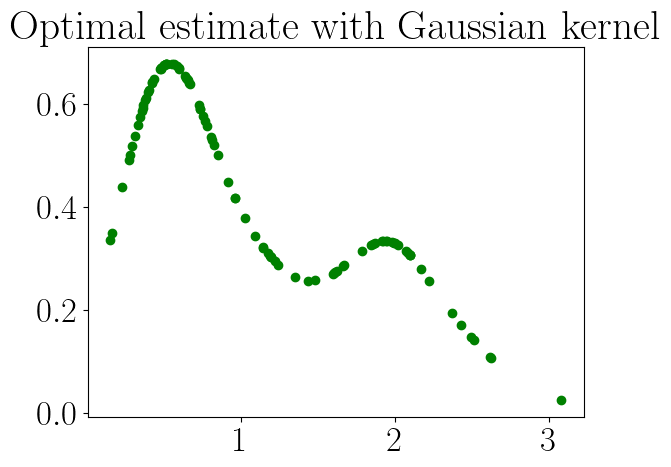

optimal bandwidth: 0.25


In [27]:
from scipy.stats import binned_statistic
bins = np.arange(0,20,20/100)
# bins
binned_mass_yr, _, _ = binned_statistic(agetab['AGE'],select_results['stellarmass'],'sum',bins=bins)
binned_mass_yr = binned_mass_yr/(2e8)
print(binned_mass_yr)

# uncorr_binned_mass_yr, _, _ = binned_statistic(agetab['AGE'],agetab['MASS'],'sum',bins=bins)
# uncorr_binned_mass_yr = uncorr_binned_mass_yr/(2e8)
# print(uncorr_binned_mass_yr)

# from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV

# bandwidth = np.arange(0.05, 2, .05)
# kde = KernelDensity(kernel='gaussian')
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(binned_mass_yr.reshape(-1,1))

# kde = grid.best_estimator_
# log_dens = kde.score_samples(binned_mass_yr.reshape(-1,1))
# plt.scatter(binned_mass_yr.reshape(-1,1), np.exp(log_dens), c='green')
# plt.title('Optimal estimate with Gaussian kernel')
# plt.show()
# print("optimal bandwidth: " + "{:.2f}".format(kde.bandwidth))

(0.0, 20.0)

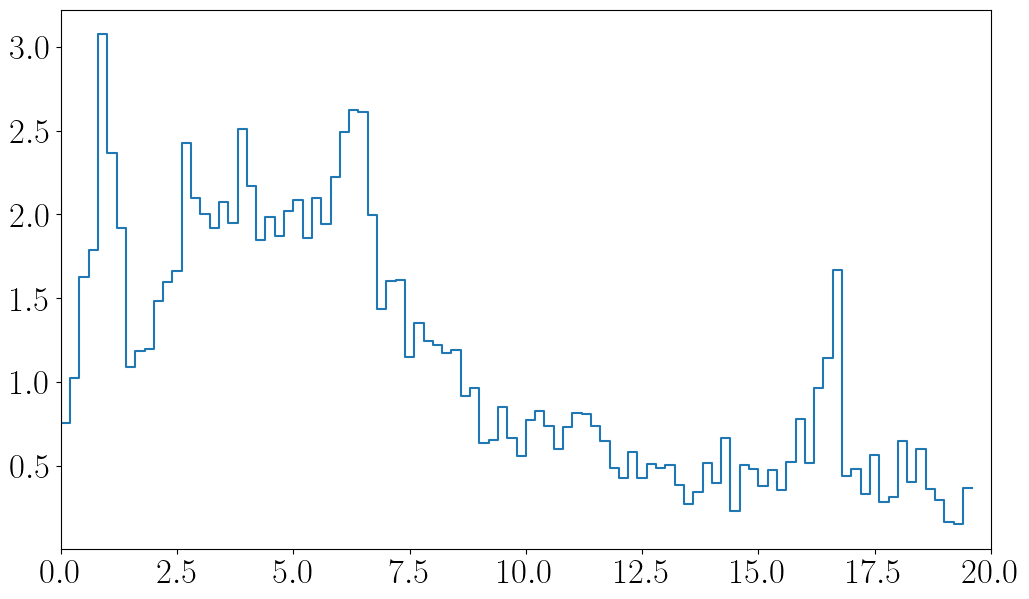

In [23]:
plt.figure(figsize=[12,7])
plt.step(bins[:-1],binned_mass_yr)
plt.xlim(0,20)

In [24]:
north['SFR']*10**-9

1.03337622284e-08
8.63440905711e-09
7.2247437577400005e-09
6.00328332156e-09
4.8871816904200005e-09
3.8741460512100005e-09
3.60818675826e-09
3.36494487307e-09
3.1447884346000003e-09
...
2.09414627633e-09


In [25]:
np.sum(select_results['stellarmass'])/10**9

23.538625709129626

In [26]:
(np.sum(north['SFR_times_area']*10**-9*(north['Age_max']-north['Age_min'])*10**9)+np.sum(south['SFR_times_area']*10**-9*(south['Age_max']-south['Age_min'])*10**9))/10**9

0.3875594170410919

In [27]:
# for i in (north['Age_max']-north['Age_min']):
#     print(i)

In [28]:
# north['Age_max']

In [29]:
lmc_area_tot = 36*np.pi*(49.9*np.tan(np.radians(0.8)))**2*10**6
lmc_area_tot

54909137.47123368

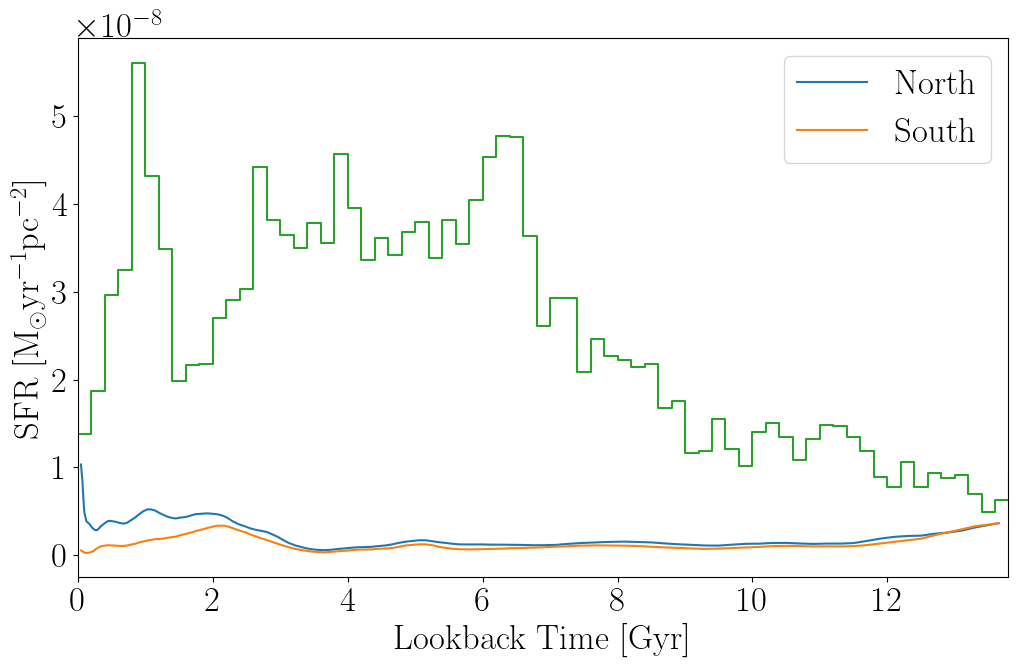

In [43]:
plt.figure(figsize=[12,7])
plt.plot((north['Age_max']+north['Age_min'])/2.,north['SFR']*10**-9,label='North')
plt.plot((south['Age_max']+south['Age_min'])/2.,south['SFR']*10**-9,label='South')
# plt.plot(binned_age,binned_mass_yr)
plt.step(bins[:-1],binned_mass_yr/lmc_area_tot)
plt.legend()
plt.xlim(0,13.787)
plt.xlabel(r'Lookback Time [Gyr]')
plt.ylabel(r'SFR [${\rm M_\odot yr^{-1} pc^{-2}}$]')
plt.show()

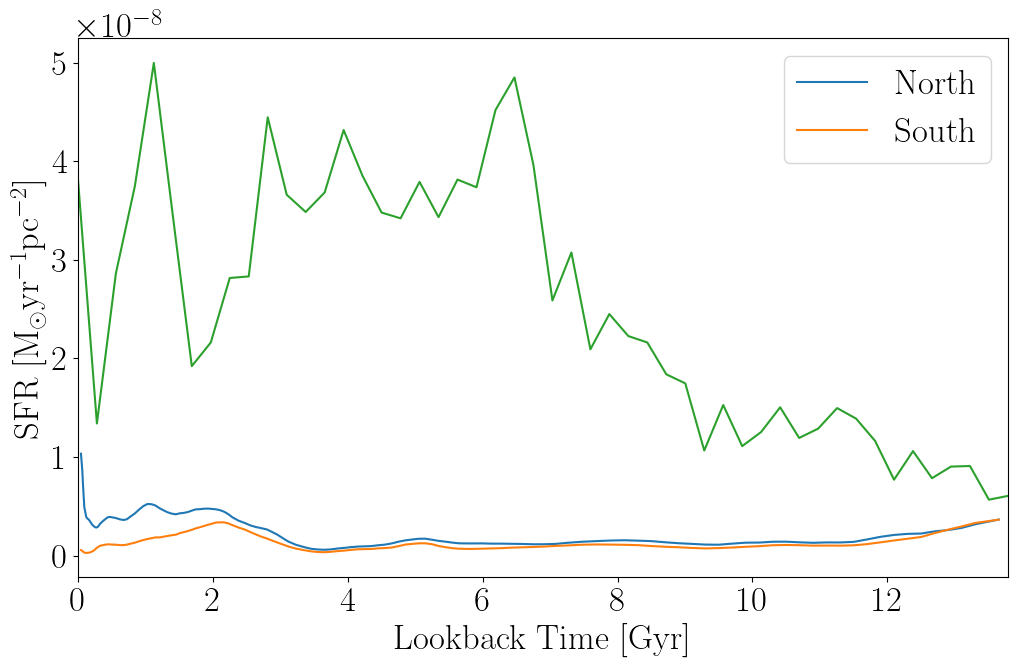

In [50]:
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
spl = InterpolatedUnivariateSpline(bins[:-1],binned_mass_yr/lmc_area_tot)

plt.figure(figsize=[12,7])
plt.plot((north['Age_max']+north['Age_min'])/2.,north['SFR']*10**-9,label='North')
plt.plot((south['Age_max']+south['Age_min'])/2.,south['SFR']*10**-9,label='South')
# plt.plot(binned_age,binned_mass_yr)
# plt.step(bins[:-1],binned_mass_yr/lmc_area_tot)
plt.plot(np.linspace(0,13.787),spl(np.linspace(0,13.787)),c='tab:green')
plt.legend()
plt.xlim(0,13.787)
plt.xlabel(r'Lookback Time [Gyr]')
plt.ylabel(r'SFR [${\rm M_\odot yr^{-1} pc^{-2}}$]')
plt.show()



In [35]:
# uncorr_binned_mass_yr/lmc_area_tot*10**7

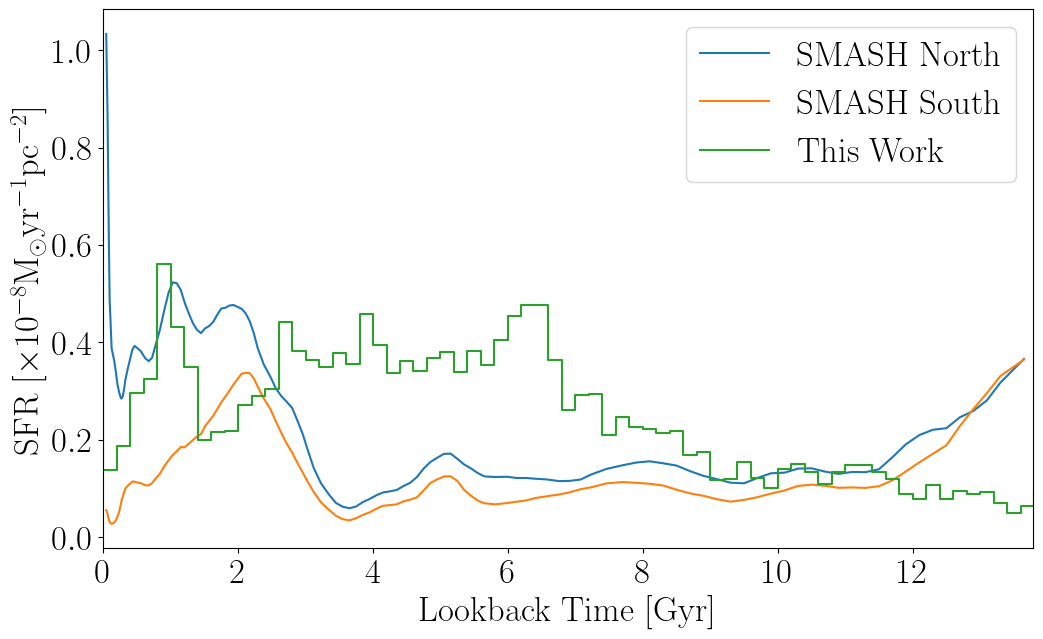

In [31]:
plt.figure(figsize=[12,7])
plt.plot((north['Age_max']+north['Age_min'])/2.,north['SFR']*10**-9*10**8,label='SMASH North')
plt.plot((south['Age_max']+south['Age_min'])/2.,south['SFR']*10**-9*10**8,label='SMASH South')
plt.step(bins[:-1],binned_mass_yr/lmc_area_tot/10*10**8,label='This Work')
# plt.step(bins[:-1],uncorr_binned_mass_yr/lmc_area_tot*10**10,label='Raw')
plt.legend()
plt.xlim(0,13.787)
plt.xlabel(r'Lookback Time [Gyr]')
plt.ylabel(r'SFR [$\times 10^{-8} {\rm M_\odot yr^{-1} pc^{-2}}$]')
plt.savefig('smash_compare_sfh.png',bbox_inches='tight')
plt.show()

[1.79955643 0.44027944 0.45874657 0.92596916 0.83528925 1.95231526
 1.21995762 1.08879816 0.41651777 0.43555818 0.57083413 0.61127044
 0.7214137  0.80331191 1.1201591  0.92101153 0.98048419 0.88769345
 0.74793677 0.87756902 1.14300656 0.87802613 0.80192933 0.9121492
 0.83145661 0.7399882  0.77169794 0.72334463 0.80596282 0.70233325
 0.70327814 0.70609025 0.96105978 1.041133   0.78718758 0.47156923
 0.43955612 0.50153489 0.3621325  0.32486691 0.43147638 0.27222507
 0.42706818 0.2552391  0.29496411 0.27518562 0.12010222 0.1219897
 0.40862717 0.10699677 0.08441091 0.12710851 0.07776423 0.07808157
 0.11501748 0.06379319 0.17505358 0.11502513 0.07753717 0.08495462
 0.08891086 0.09215066 0.08119102 0.05105513 0.15514368 0.12084473
 0.1951528  0.11208776 0.06400131 0.14318484 0.18845827 0.10586929
 0.2736441  0.03389931 0.17771758 0.10499493 0.18158077 0.14312416
 0.07313188 0.14693672 0.16773653 0.12148193 0.44998601 0.28818444
 0.81031791 0.11517085 0.11202486 0.03697585 0.11774576 0.037232

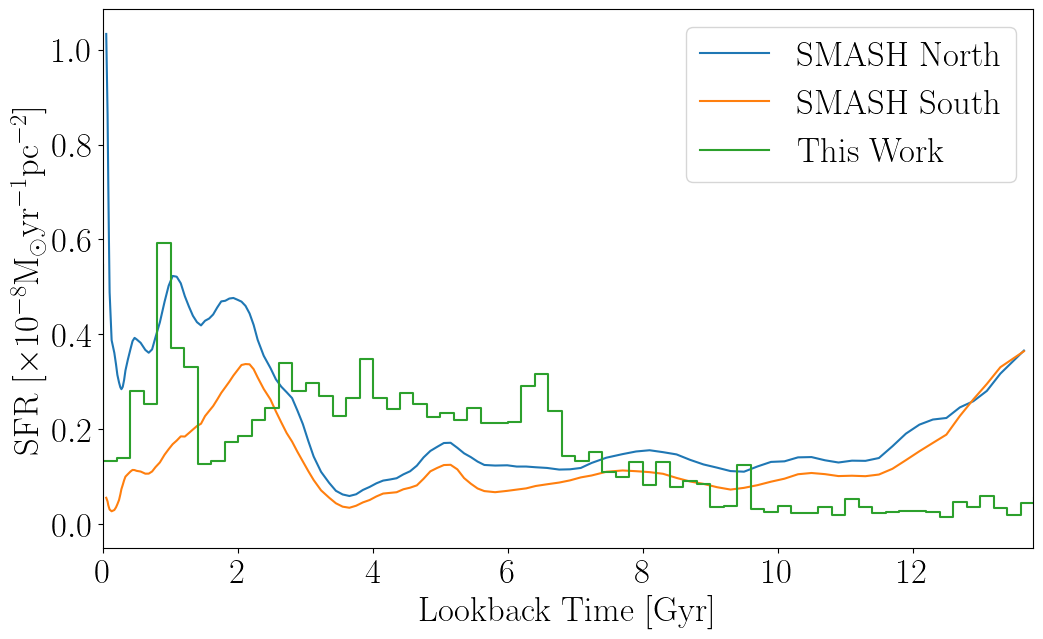

In [32]:
ang_rad_cut, = np.where(lmcdr17['LMCRAD']<=5.0)
bins = np.arange(0,20,20/100)
binned_mass_yr2, _, _ = binned_statistic(agetab['AGE'][ang_rad_cut],select_results['stellarmass'][ang_rad_cut],'sum',bins=bins)
binned_mass_yr2 = binned_mass_yr2/(2e8)
print(binned_mass_yr2)

plt.figure(figsize=[12,7])
plt.plot((north['Age_max']+north['Age_min'])/2.,north['SFR']*10**-9*10**8,label='SMASH North')
plt.plot((south['Age_max']+south['Age_min'])/2.,south['SFR']*10**-9*10**8,label='SMASH South')
plt.step(bins[:-1],binned_mass_yr2/lmc_area_tot*(10**8)/6,label='This Work')
# plt.step(bins[:-1],binned_mass_yr/lmc_area_tot)
# plt.step(bins[:-1],uncorr_binned_mass_yr/lmc_area_tot*10**10,label='Raw')
plt.legend()
plt.xlim(0,13.787)
plt.xlabel(r'Lookback Time [Gyr]')
plt.ylabel(r'SFR [$\times 10^{-8} {\rm M_\odot yr^{-1} pc^{-2}}$]')
# plt.savefig('smash_compare_sfh.png',bbox_inches='tight')
plt.show()

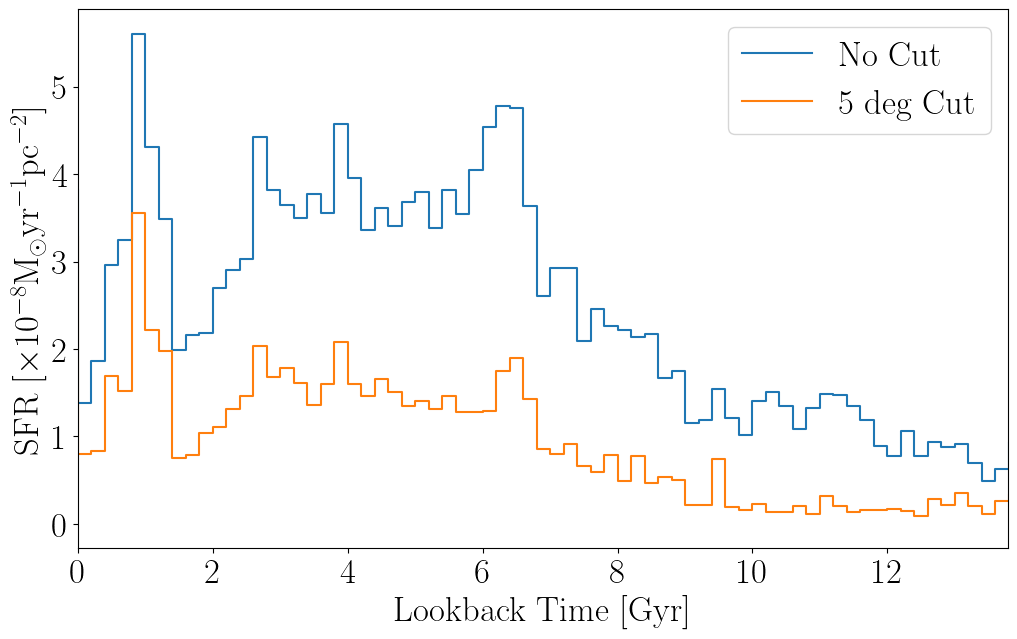

In [37]:
plt.figure(figsize=[12,7])
plt.step(bins[:-1],binned_mass_yr/lmc_area_tot*(10**8),label='No Cut')
plt.step(bins[:-1],binned_mass_yr2/lmc_area_tot*(10**8),label='5 deg Cut')
plt.legend()
plt.xlim(0,13.787)
plt.xlabel(r'Lookback Time [Gyr]')
plt.ylabel(r'SFR [$\times 10^{-8} {\rm M_\odot yr^{-1} pc^{-2}}$]')
plt.show()

In [35]:
len(ang_rad_cut)

2539

(array([ 171.,  217.,  905.,  800.,  936., 1139.,  929.,  473.,  438.,
         122.]),
 array([ 0.08242882,  1.1839851 ,  2.2855415 ,  3.3870978 ,  4.488654  ,
         5.5902104 ,  6.6917667 ,  7.793323  ,  8.894879  ,  9.996435  ,
        11.097992  ], dtype=float32),
 <BarContainer object of 10 artists>)

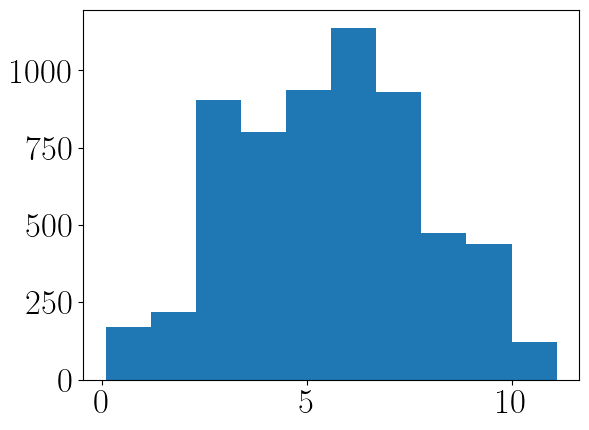

In [34]:
plt.hist(lmcdr17['LMCRAD'])

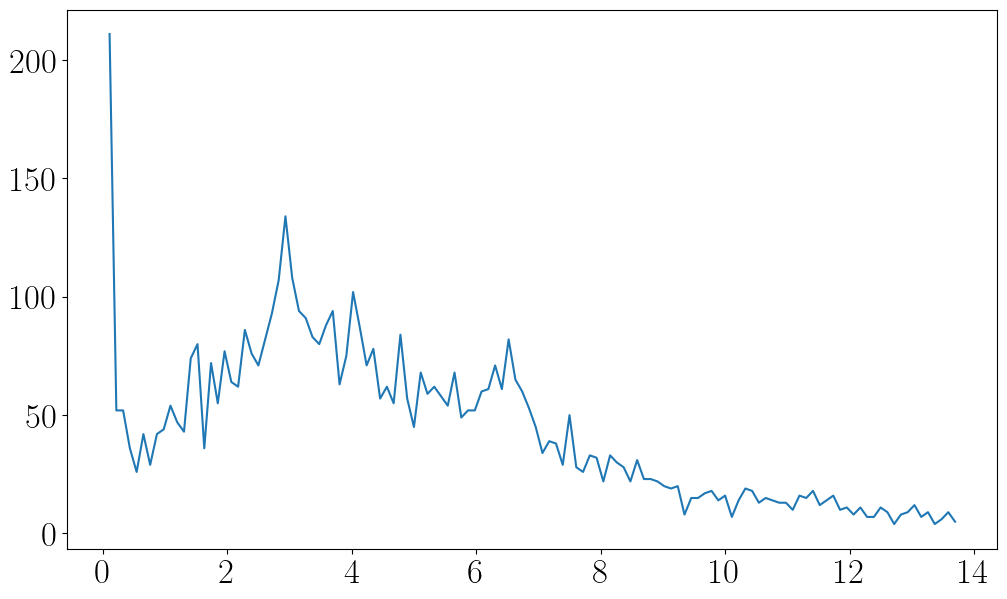

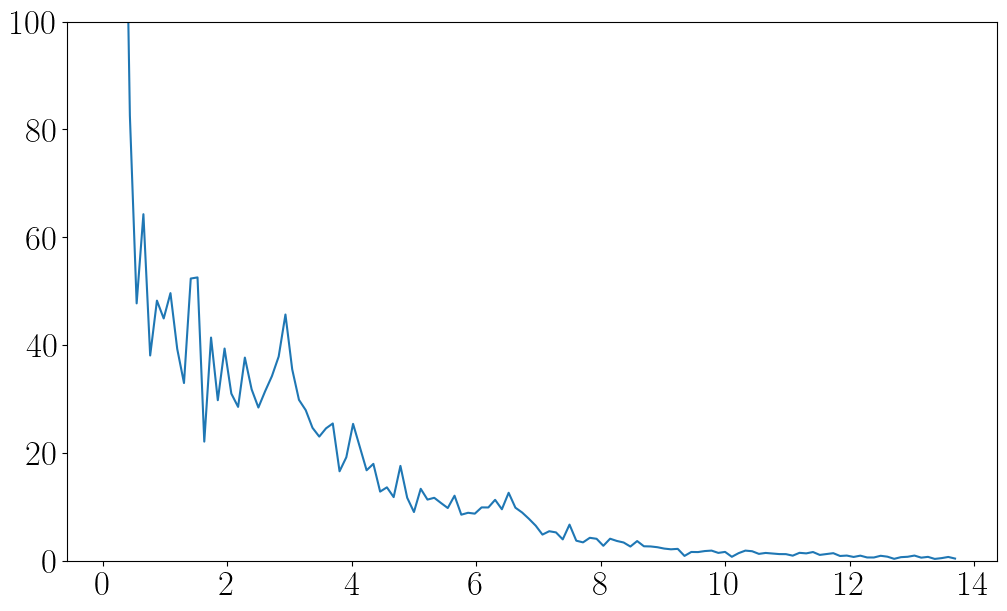

In [76]:
from scipy.stats import binned_statistic

masscut = np.where((agetab['MASS']<10)&(agetab['AGE']<13.787))

bin_stats, bin_edges, bin_number = binned_statistic(agetab['AGE'][masscut],agetab['MASS'][masscut],
                                                    statistic='count',bins=len(north['Age_max']))

bin_centers = bin_edges[:-1]+np.median(np.diff(bin_edges))/2

plt.figure(figsize=[12,7])
plt.plot(bin_centers,bin_stats)
plt.show()

plt.figure(figsize=[12,7])
plt.plot(bin_centers,bin_stats/bin_centers)
plt.ylim(0,100)
plt.show()

In [ ]:
select_results = Table.read('lmc_rgbmembers_selectfunc.fits.gz')

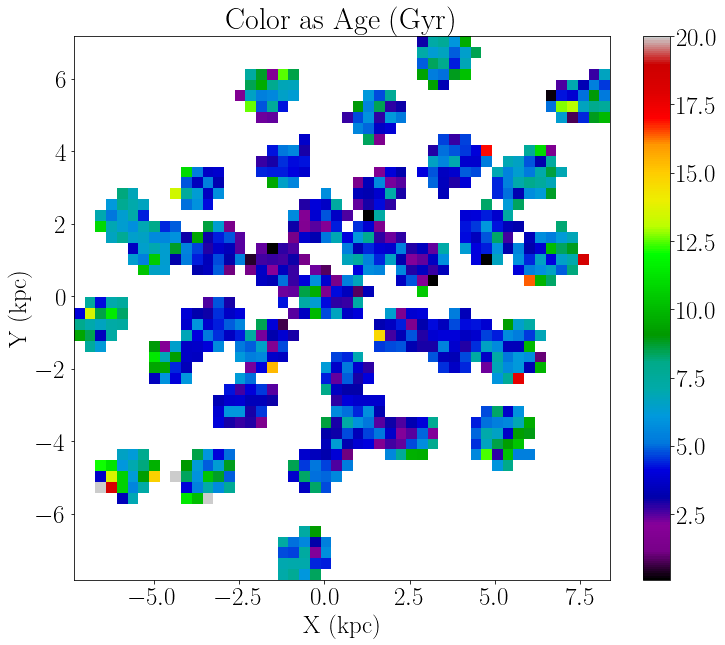

In [146]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.title(r'Color as Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
plt.savefig('../plots/lmc_map_age.png',bbox_inches='tight')
plt.show()

In [32]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import binned_statistic

### MLE Functions

def linmodl(m,b,x):
    '''
    Slope-intercept form of a line
    
    Parameters:
    ----------
        m: slope of line
        x: exog of line
        b: intercept of line
        
    Returns:
    -------
        y: endog of line
    '''
    y = m*x + b
    return y

def lnL(theta,x,y,yerr):
    '''
    Log likelihood for linmodl
    
    Parameters:
    ----------
        theta: parameters to plug into linmodl (m,b)
        x: exog of line
        y: endog of line
        yerr: endog error
    
    Returns:
    -------
        lnl: log likelihood 
    '''
    
    m, b = theta
    modl = linmodl(m,b,x)
    inv_sig2 = np.reciprocal(np.square(yerr))
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

### MCMC Specific

def lnPrior(theta):
    '''
    Using a flat prior to calculate the log prior
    
    Parameters:
    ----------
    theta: model parameters
    
    '''
    m, b = theta
    if -1.0 < m < 1.0 and -2.0 < b < 2.0:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, yerr):
    '''
    Calculate the log probability
    
    Parameters:
    ----------
    theta: model parameters
    x: x coordinate data
    y: y coordinate data
    y_err: y error
    
    '''
    
    lnP = lnPrior(theta)
    if not np.isfinite(lnP):
        return -np.inf
    return lnP + lnL(theta, x, y, yerr)

def MLELinearParameters(rad,age,bin_width):
    '''
    Calculate the MLE parameters for a linear abundance trend
    
    Inputs:
    ------
        rad:         array-like
                     radial coordinate
        
        age:         array-like
                     ages
                     
        
        #age_err:     array-like
        #             error in ages
                     
        bin_width:   float
                     width of bin
        
    Outputs:
    ------- 
        mle_m,mle_b: floats
                     MLE parameters
    '''
    
    # bin data and calculate statistic and error for each bin
    bins = np.arange(np.floor(np.min(rad)),np.ceil(np.max(rad))+bin_width,bin_width)
    bin_stats, _, _ = binned_statistic(rad,age,statistic='median',bins=bins)
    
    # get MAD of each bin
    bin_stats_err, _, _ = binned_statistic(rad,age,statistic=lambda y: mad(y),bins=bins)
    
    # shift radial values to center of bins
    center_rad_bins = np.delete(bin_edges,-1)+0.5*bin_width
    
    # calculate guess for MLE
    m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
    b_guess = bin_stats[0]
    
    # do MLE with log likelihood (lnL)
    nll = lambda *args: -lnL(*args)
    initial = np.array([m_guess, b_guess]) + 0.1 * np.random.randn(2)
    soln = minimize(nll, initial, args=(center_rad_bins, bin_stats, bin_stats_err))
    mle_m, mle_b = soln.x
    
    # Initialize MCMC
    pos = np.array([mle_m,mle_b]) + 1e-4 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnProb, args=(center_rad_bins, bin_stats, bin_stats_err)
    )
    sampler.run_MCMC(pos,5000,progress=True)
    
    # Plot
    fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
    samples = sampler.get_chain()
    labels = ["m", "b"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    return mle_m,mle_b

In [33]:
cln = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']!=999999.0)&(lmcdr17['SNR']>100.))

mle_m, mle_b = MLELinearParameters(lmcr[cln],agetab['AGE'][cln],1.0)
print(mle_m)
print(mle_b)

AttributeError: 'EnsembleSampler' object has no attribute 'run_MCMC'

In [41]:
import emcee

pos = np.array([mle_m,mle_b]) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnProb, args=(lmcr[cln], agetab['AGE'][cln], agetab['AGE_ERR'][cln])
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:02<00:00, 2083.31it/s]


In [163]:
cln = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']!=999999.0)&(lmcdr17['SNR']>100.))
rad = lmcr[cln]
age = agetab['AGE'][cln]
bin_width = 0.5

# bin data and calculate statistic and error for each bin
bins = np.arange(np.floor(np.min(rad)),np.ceil(np.max(rad))+bin_width,bin_width)
bin_stats, bin_edges, _ = binned_statistic(rad,age,statistic='median',bins=bins)

# # get MAD of each bin
bin_stats_err, _, _ = binned_statistic(rad,age,statistic=mad,bins=bins)#lambda y: mad(y)

# # shift radial values to center of bins
center_rad_bins = np.delete(bin_edges,-1)+0.5*bin_width

fincut, = np.where((np.isfinite(bin_stats)==True)&(np.isfinite(bin_stats_err)==True))#&(bin_stats_err!=0.))
bin_stats = bin_stats[fincut]
bin_stats_err = bin_stats_err[fincut]
center_rad_bins = center_rad_bins[fincut]

# calculate guess for MLE
m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
b_guess = bin_stats[0]

# do MLE with log likelihood (lnL)
nll = lambda *args: -lnL(*args)
initial = np.array([m_guess, b_guess]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(lmcr, agetab['AGE'], agetab['AGE_ERR']))
mle_m, mle_b = soln.x

# # Initialize MCMC
# pos = np.array([mle_m,mle_b]) + 1e-2 * np.random.randn(32, 2)
# nwalkers, ndim = pos.shape
# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, lnProb, args=(lmcr[cln], agetab['AGE'][cln], agetab['AGE_ERR'])
# )
# sampler.run_mcmc(pos, 10000, progress=True);

# # Plot
# fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
# samples = sampler.get_chain()
# labels = ["m", "b"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [164]:
bin_stats_err

array([3.92512889, 3.72349031, 3.46544136, 3.30352069, 3.12526768,
       3.16725737, 2.56733809, 2.2861519 , 2.63767251, 2.80483142,
       3.51236498, 3.22207745, 3.75508353, 3.63192943, 1.03410142,
       0.82770962, 1.91697531, 0.        ])

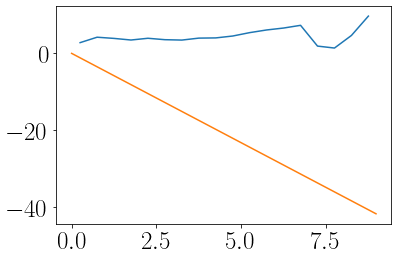

In [130]:
fincut, = np.where((np.isfinite(bin_stats)==True)&(np.isfinite(bin_stats_err)==True))
plt.plot(center_rad_bins[fincut],bin_stats[fincut])
plt.plot(np.linspace(0,max(lmcr)),mle_m*np.linspace(0,max(lmcr)+mle_b))

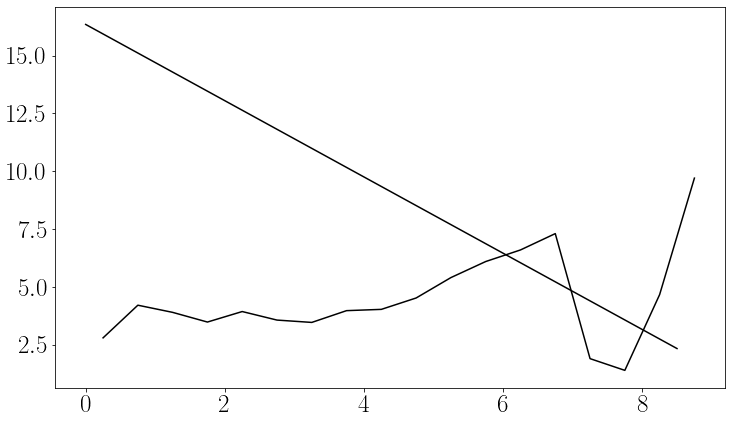

In [131]:
plt.figure(figsize=[12,7])
# plt.scatter(lmcr[cln],agetab['AGE'][cln])
plt.plot(center_rad_bins, bin_stats,c='k')
plt.plot(np.linspace(0,8.5),mle_m*np.linspace(0,8.5)+mle_b,c='k')
# plt.ylim(0,20)

(0.0, 20.0)

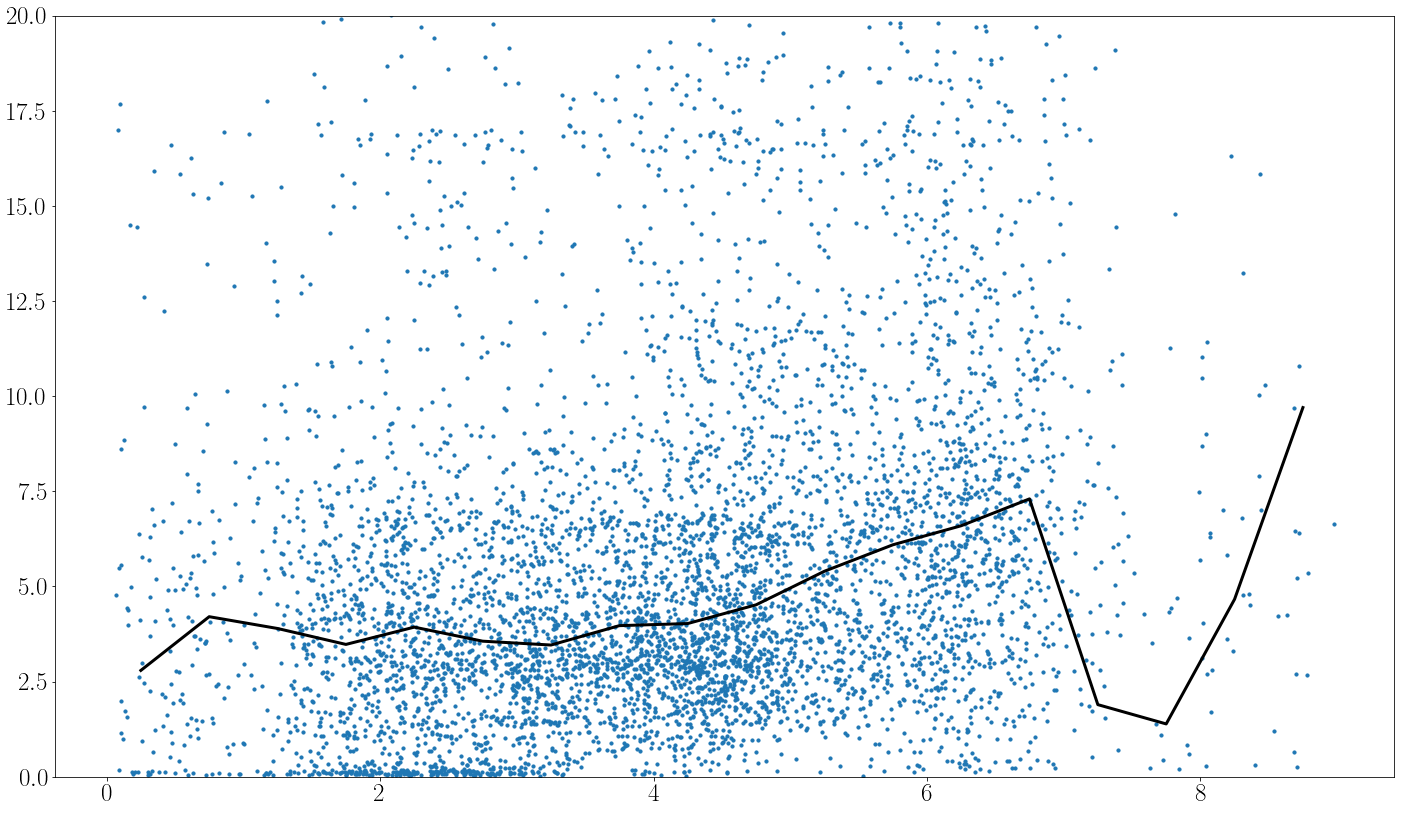

In [161]:
plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],s=10)
plt.plot(center_rad_bins,bin_stats,c='k',lw=3)
plt.ylim(0,20)

In [208]:
med_fld_age = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))
mad_fld_age = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_centers = 999999.0*np.ones((len(np.unique(lmcdr17['FIELD'])),2))

fld_radius = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

for i in range(len(np.unique(lmcdr17['FIELD']))):
    fld, = np.where(lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])
    
    med_fld_age[i] = np.nanmedian(agetab['AGE'][fld])
    mad_fld_age[i] = mad(agetab['AGE'][fld])
    
    medx = np.nanmedian(lmcx[fld])
    medy = np.nanmedian(lmcy[fld])
    
    fld_centers[i,0] = medx
    fld_centers[i,1] = medy
    
    fld_radius[i] = np.nanmedian(lmcr[fld])

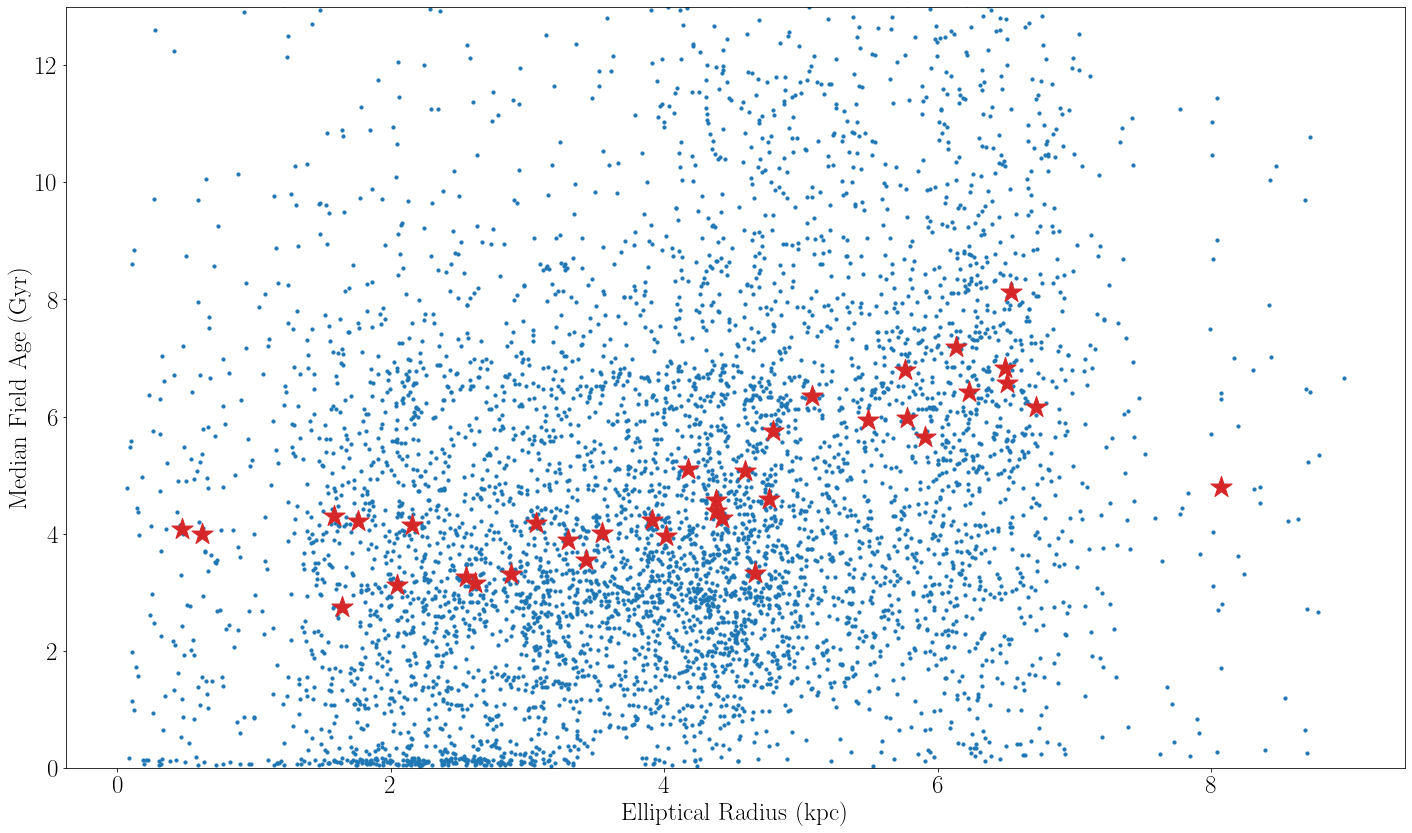

In [223]:
plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],c='tab:blue',s=10)
plt.scatter(fld_radius,med_fld_age,c='tab:red',marker='*',s=500)
# plt.plot(center_rad_bins,bin_stats,c='k',lw=3)
plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
plt.savefig('lmc_fld_age_radius.png',bbox_inches='tight')
plt.show()

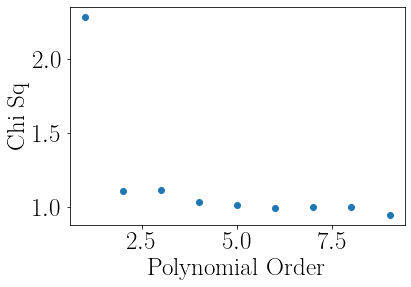

In [232]:
chi_sq = []

sidx = np.argsort(fld_radius)
for i in range(10)[1:]:
    
    p = np.poly1d(np.polyfit(fld_radius[sidx][:-1],med_fld_age[sidx][:-1],i))
    
    chi_sq.append(sum(np.square(np.divide(med_fld_age[sidx][:-1]-p(fld_radius[sidx][:-1]),mad_fld_age[sidx][:-1])))) #/(len(fld_radius[:-1]-(i+1))))
    
chi_sq = np.array(chi_sq)
    
plt.scatter(range(10)[1:],chi_sq)
plt.xlabel(r'Polynomial Order')
plt.ylabel(r'Chi Sq')
plt.savefig(r'chisq_age_radius_polyfit.png',bbox_inches='tight')
plt.show()

In [36]:
p2 = np.poly1d(np.polyfit(fld_radius[sidx][:-1],med_fld_age[sidx][:-1],2))

plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[:-1],med_fld_age[:-1],c='tab:red',marker='.',s=500)
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p2(xs_rads),c='k',lw=3)
plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

NameError: name 'fld_radius' is not defined

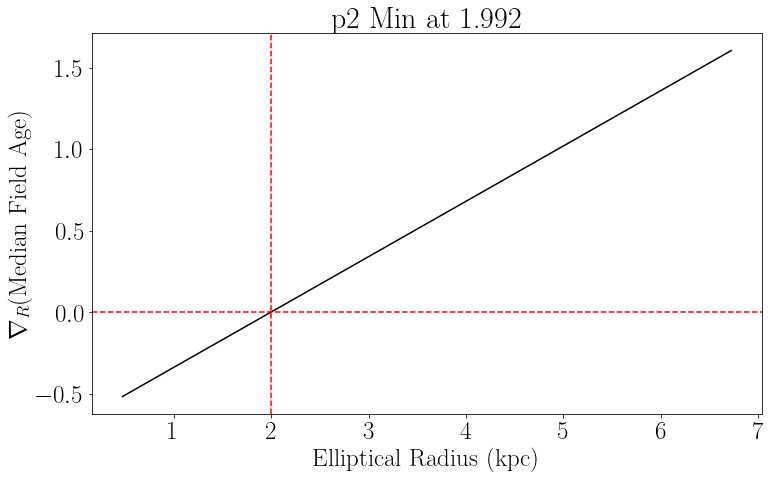

In [252]:
plt.figure(figsize=[12,7])
plt.plot(xs_rads,p2.deriv()(xs_rads),c='k')
plt.axvline(p2.deriv().roots,ls='--',c='r')
plt.axhline(0,ls='--',c='r')
plt.title(r'p2 Min at {:.3f}'.format(p2.deriv().roots[0]))
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'$\nabla_R$(Median Field Age)')
plt.show()

In [241]:
p2.deriv().roots

array([1.99246934])